In [1]:
from cmeutils.structure import (
    bond_distribution,
    angle_distribution,
    dihedral_distribution,
)
from cmeutils.plotting import get_histogram, savitzky_golay
from polybinderCG.coarse_grain import System

import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np
import signac


import os

/home/chrisjones4/miniconda3/envs/pekkcg-analysis/lib/python3.11/site-packages/mbuild/utils/io.py:29: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename
/home/chrisjones4/miniconda3/envs/pekkcg-analysis/lib/python3.11/site-packages/pkg_resources/__init__.py:3144: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/chrisjones4/miniconda3/envs/pekkcg-analysis/lib/python3.11/site-packages/mdtraj/formats/__init__.py:13: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from mdtraj.formats.trr import TRRTrajectoryFile
/home/chrisjones4/miniconda3/envs/pekkcg-analysis/lib/python

# Functions and matplotlib config:

In [2]:
def moving_average_smoothing(raw_data, w):
        return np.convolve(raw_data, np.ones(w), "same")/w

def hoomd_dihedral(phi, phi0, k, d, n):
    return 0.5*k*(1+d*np.cos(n*phi - phi0))

def bond_harmonic(l, l0, k):
    return (0.5*k*(l-l0)**2)
    
# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
symbol_dict = {1.0: "o", 0.8: "s", 0.7: "^", 0.6: "d"}
pair_symbol_dict = {"E-E": "o", "K-K": "s", "E-K": "^"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 2
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.marker"] = "o"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200

label_conv = {
    0.60: "60/40",
    0.70: "70/30",
    0.80: "80/20",
    1.0: "100/0",
}

# Signac Projects:

In [3]:
# Target single chain sims used to obtain distributions:
project = signac.get_project("../learning-runs/single-chains/")
cg_project = signac.get_project("../coarse-grain-sims/single-chain-pl-rg-re/polybinder-flow/")

# Angles <a name="bondangles"></a>

<>:43: DeprecationWarning: invalid escape sequence '\T'
<>:44: DeprecationWarning: invalid escape sequence '\T'
<>:43: DeprecationWarning: invalid escape sequence '\T'
<>:44: DeprecationWarning: invalid escape sequence '\T'
/tmp/ipykernel_973130/1813375304.py:43: DeprecationWarning: invalid escape sequence '\T'
  plt.xlabel("$\Theta$ [rad]")
/tmp/ipykernel_973130/1813375304.py:44: DeprecationWarning: invalid escape sequence '\T'
  plt.ylabel("P($\Theta$)")


58c288176f33a2b9724fca9db9bd2c7d 0.6 [20] 6.5
0f2d30692a6cdb8fd90ae3f6aec03a03 0.6 [20] 6.5
25b86c178710cea698587986d2d95770 0.6 [20] 6.5
99b6b788140f1cfd4fa0688e674b1d16 0.6 [20] 6.5
a29bb34407e890c5ad77525cc68782f4 0.6 [20] 6.5
dde5b606206130b8a3edb7d71f020e10 0.7 [20] 6.5
c3aacbbbd5c5a92943470e412c219a69 0.7 [20] 6.5
d91373ad545adcc63bbdbd01d808c653 0.7 [20] 6.5
38e28bcc5ef00d32fd078c86ad2807ba 0.7 [20] 6.5
15d78a943140ecc3a42e0397aeec8417 0.7 [20] 6.5
0dff70a31e9cd621375562ce450ea216 0.8 [20] 6.5
1bc237b68a0cea02ebf4cf35dd06ecbb 0.8 [20] 6.5
b83dce273531102fa2c624e593dddb4c 0.8 [20] 6.5
7cf90b07988ab11e743e3d8e1195c357 0.8 [20] 6.5
d0e0a11b7d9c609601d4e2081003c105 0.8 [20] 6.5
74893c83a4f72c3353a65b589e3068bc 1.0 [20] 6.5
2bb04a322a0faabe47ac1ee1e76e9a2b 1.0 [20] 6.5
df29f22df4bcbb519383138999d89439 1.0 [20] 6.5
2fb2940d4f9e1ed762fe8afc70c3d266 1.0 [20] 6.5
406ebab1bb7367f5094f47bcde8b8e44 1.0 [20] 6.5


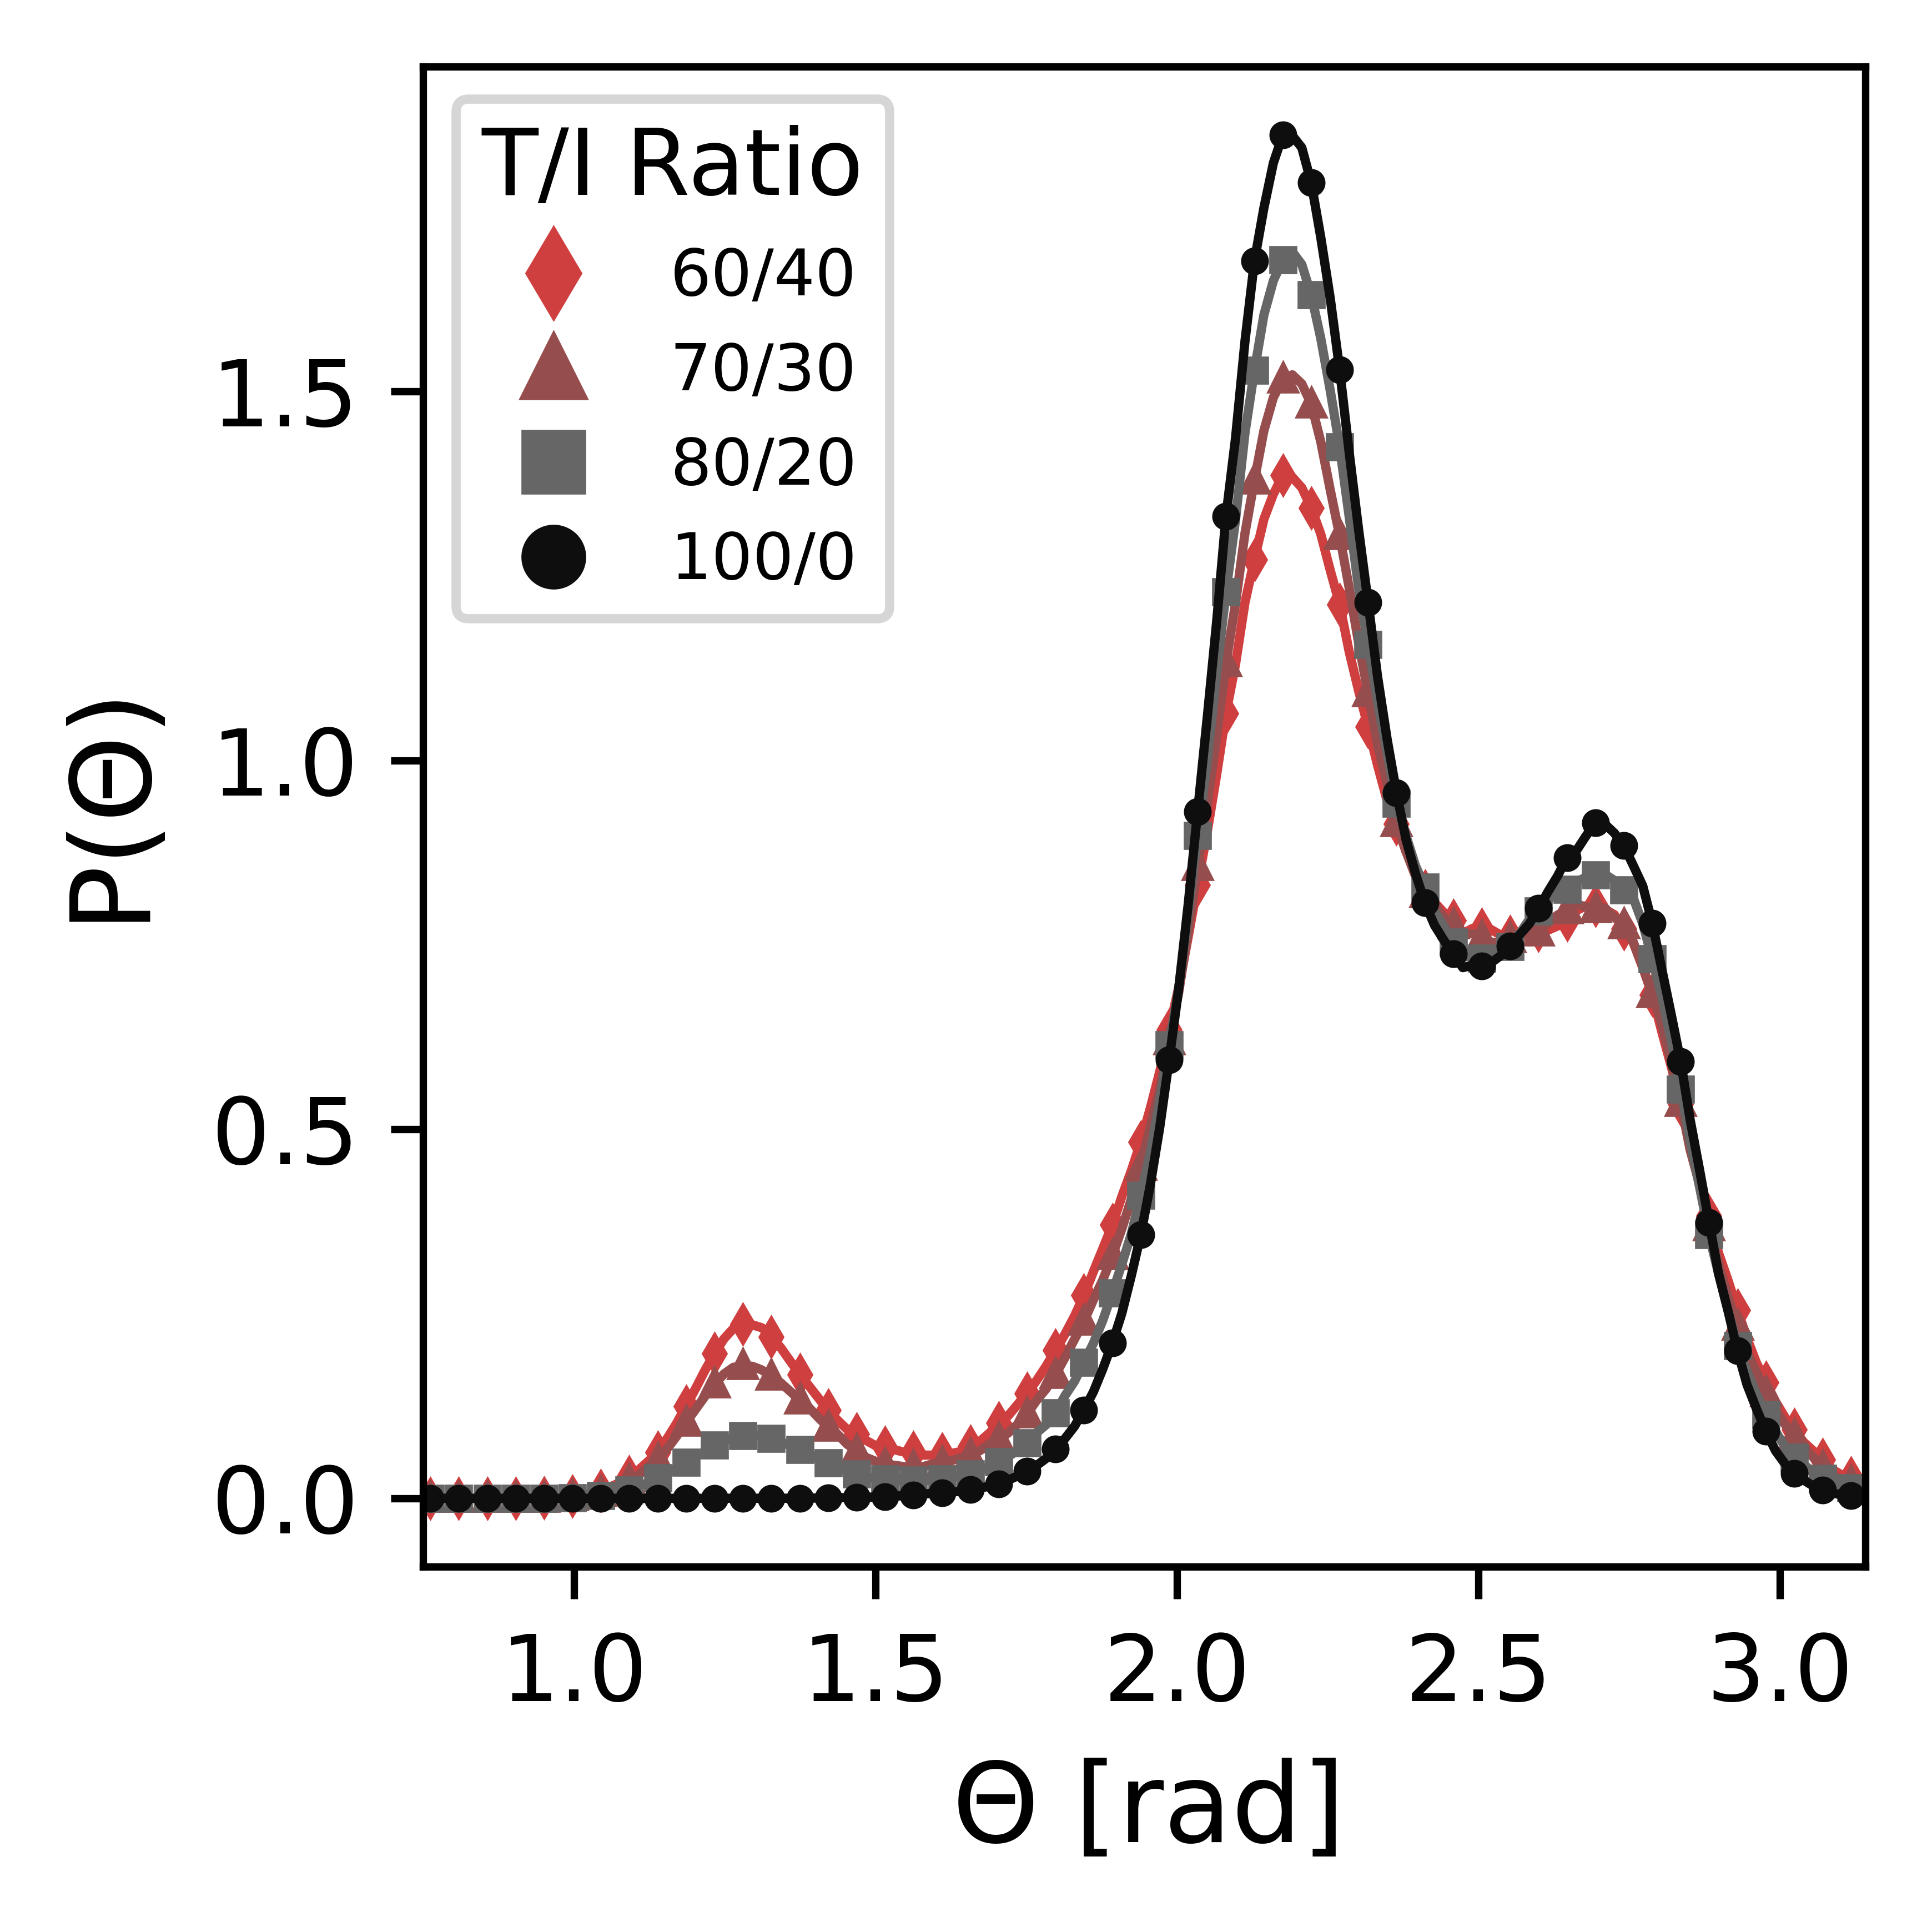

In [7]:
fig = plt.figure()
kT = 6.5
angle = "EKK"
nbins = 200
weights = []
avg_dists = []

for weight, jobs in project.find_jobs(
    filter={"polymer_lengths": (20,), "kT_quench": kT}).groupby("para_weight"):
    weight_dist = np.zeros(nbins)
    for job in jobs:
        print(job.id, job.sp.para_weight, job.sp.polymer_lengths, job.sp.kT_quench)
        adist = angle_distribution(
            gsd_file = job.fn("components.gsd"),
            A_name=angle[0],
            B_name=angle[1],
            C_name=angle[2],
            start=-1000,
            histogram=True,
            normalize=True,
            bins=nbins
        )
        smooth = savitzky_golay(adist[:,1], window_size=7, order=1)
        weight_dist += smooth

    weights.append(weight)
    avg_dists.append(weight_dist/5)
    stride = np.arange(0, len(adist[:,0]), 3)
    plt.plot(adist[:,0], weight_dist/5, c=color_dict[weight], marker=symbol_dict[weight], markersize=0)
    plt.plot(
        adist[:,0][stride],
        weight_dist[stride]/5,
        label=label_conv[weight],
        c=color_dict[weight],
        marker=symbol_dict[weight],
        linewidth=0
    )
    save_distribution = np.stack((adist[:,0], weight_dist/5)).T
    path = f"../learning-runs/single-chains/average_target_angle_dists/{kT}kT/{angle.lower()}_target_dist{kT}kT_{weight}_TI.txt"
    np.savetxt(path, save_distribution)
    
plt.legend(title="T/I Ratio", loc="upper left", markerscale=3)
plt.xlabel("$\Theta$ [rad]")
plt.ylabel("P($\Theta$)")
plt.xlim(0.75, np.pi)
fig.tight_layout()
plt.savefig(f"figures/{angle}-angle-dist-{kT}kT.png")

# Dihedrals: <a name="bonddihedrals"></a>

<>:43: DeprecationWarning: invalid escape sequence '\P'
<>:44: DeprecationWarning: invalid escape sequence '\P'
<>:45: DeprecationWarning: invalid escape sequence '\p'
<>:45: DeprecationWarning: invalid escape sequence '\p'
<>:43: DeprecationWarning: invalid escape sequence '\P'
<>:44: DeprecationWarning: invalid escape sequence '\P'
<>:45: DeprecationWarning: invalid escape sequence '\p'
<>:45: DeprecationWarning: invalid escape sequence '\p'
/tmp/ipykernel_973130/3499120441.py:43: DeprecationWarning: invalid escape sequence '\P'
  ax.set_xlabel("$\Phi$ [rad]")
/tmp/ipykernel_973130/3499120441.py:44: DeprecationWarning: invalid escape sequence '\P'
  ax.set_ylabel("P($\Phi$)")
/tmp/ipykernel_973130/3499120441.py:45: DeprecationWarning: invalid escape sequence '\p'
  ax.set_xticks([-np.pi, 0, np.pi], ["-$\pi$", 0, "$\pi$"])
/tmp/ipykernel_973130/3499120441.py:45: DeprecationWarning: invalid escape sequence '\p'
  ax.set_xticks([-np.pi, 0, np.pi], ["-$\pi$", 0, "$\pi$"])


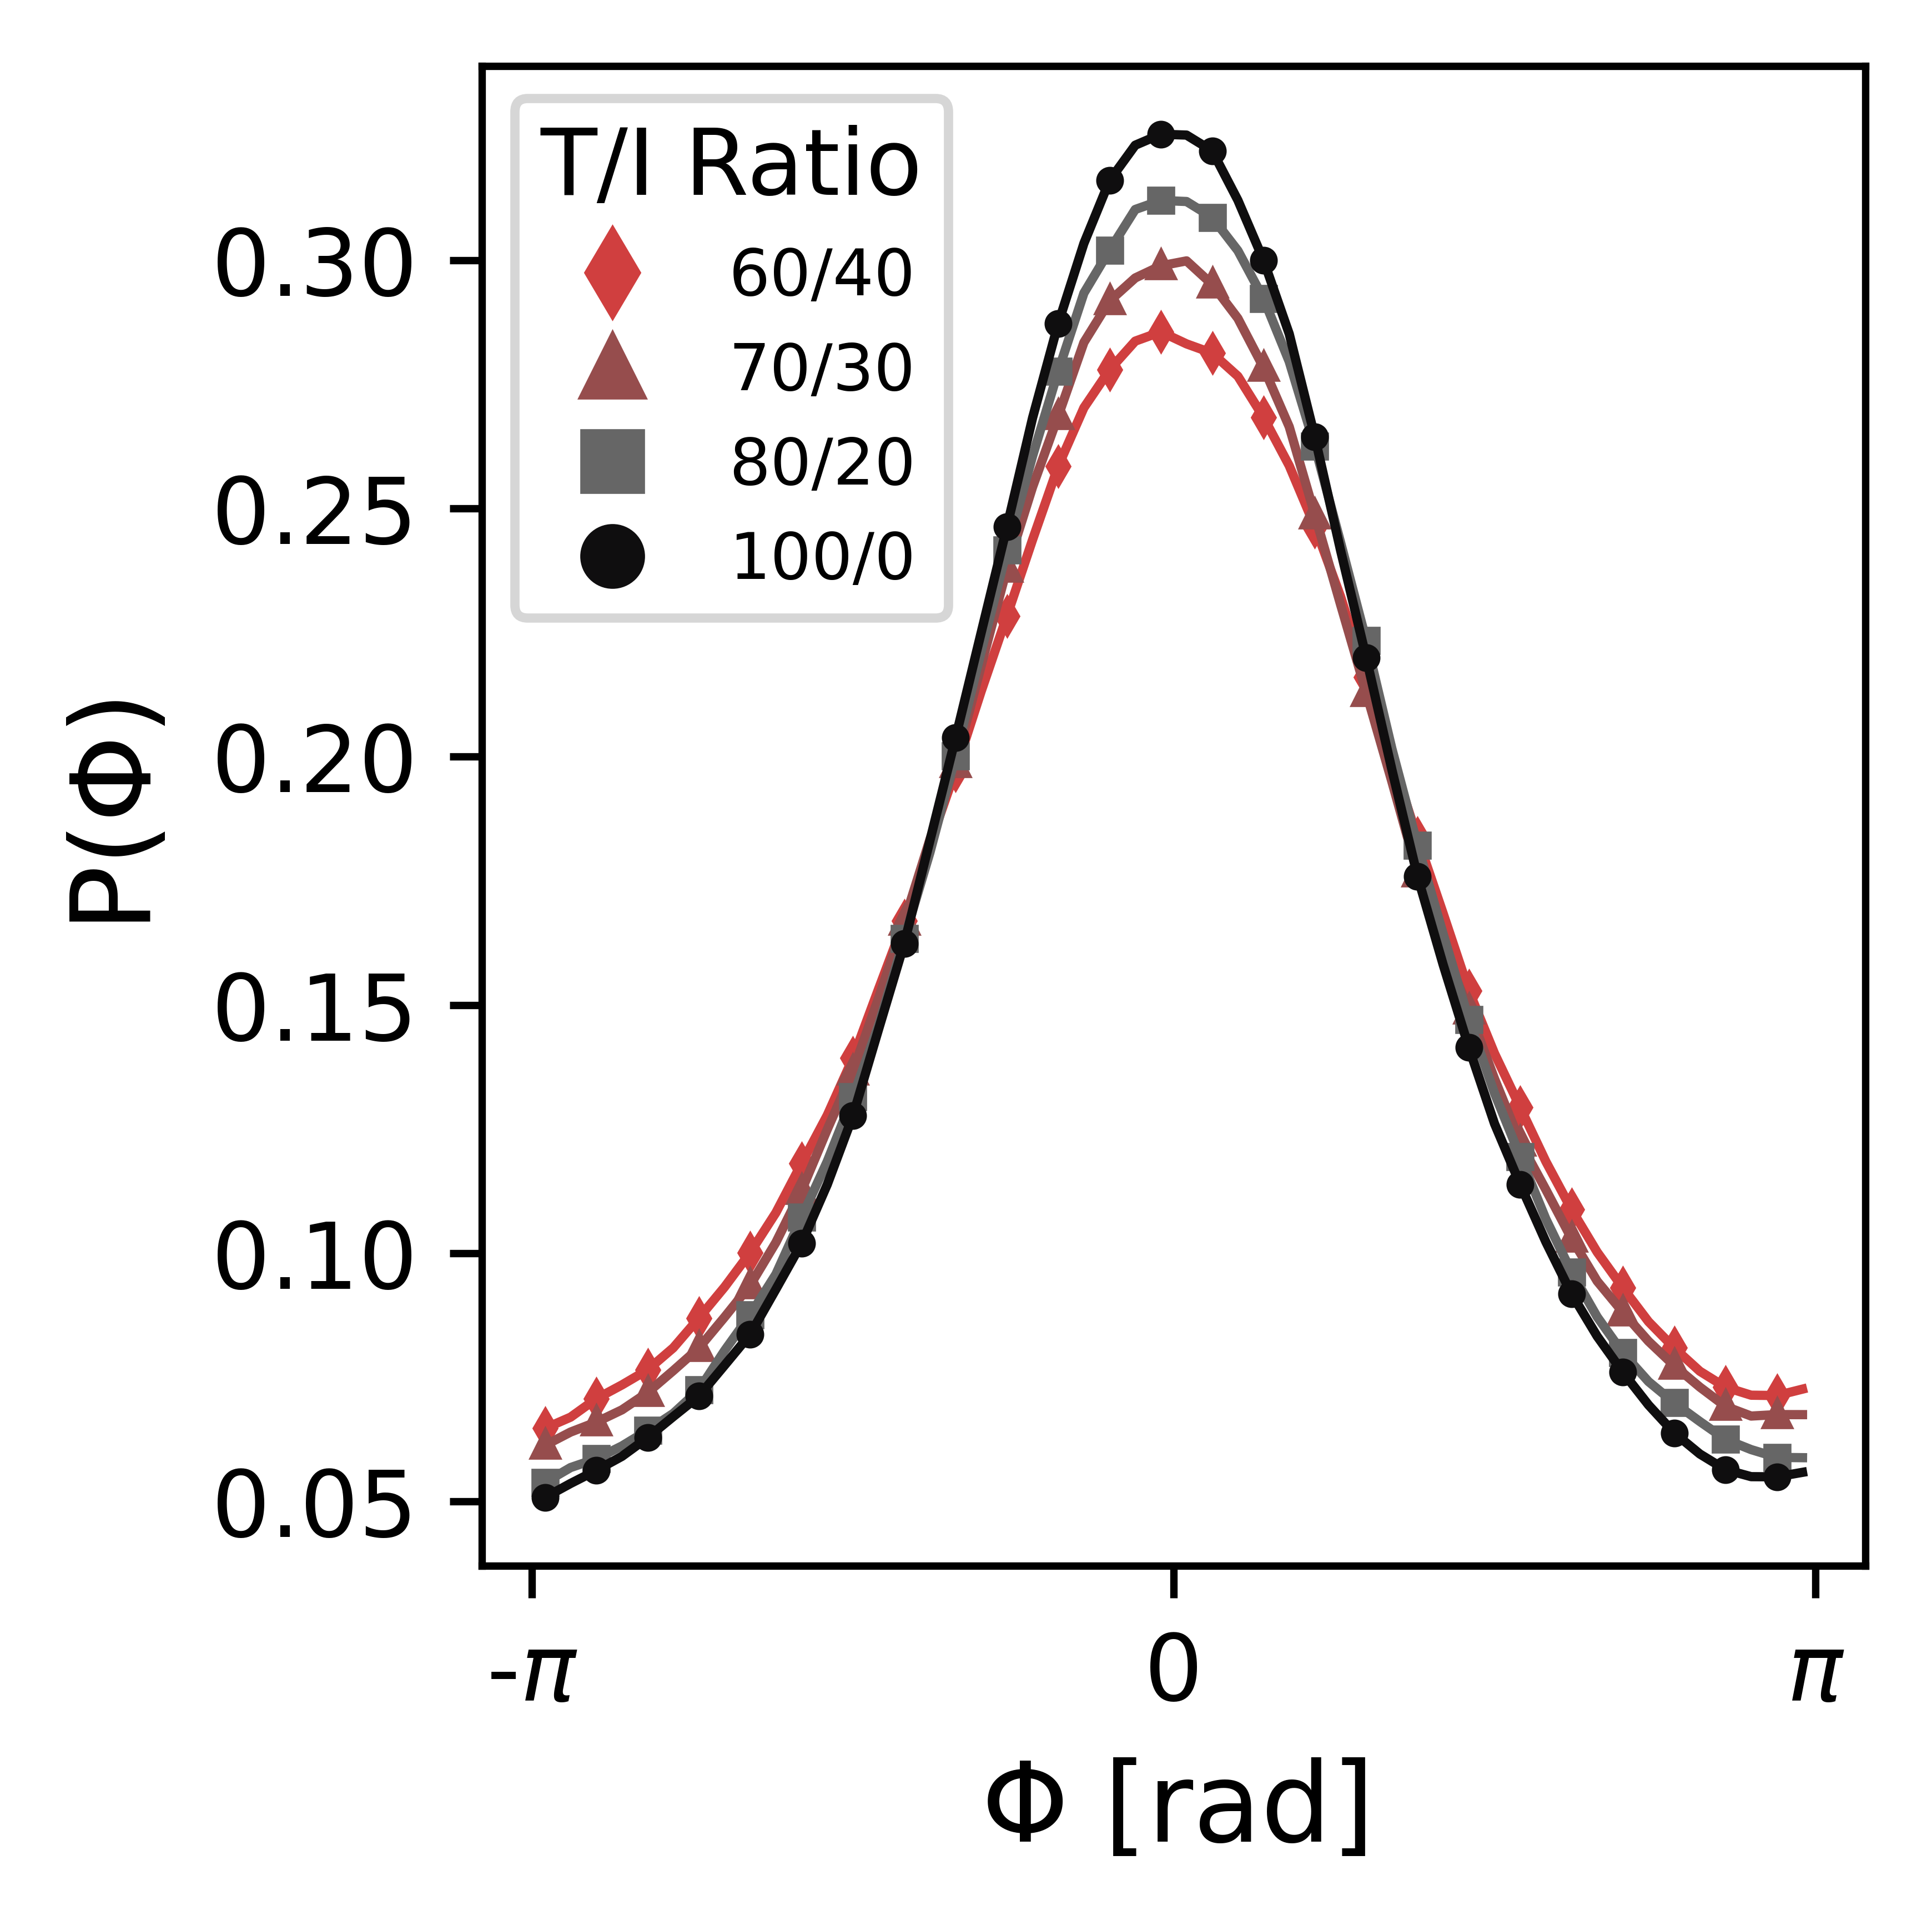

In [8]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
kT = 6.5
dihedral = "KEKK"
n_bins = 50

weights = []
avg_dists = []
for weight, jobs in project.find_jobs(filter={"polymer_lengths": [20], "kT_quench": kT}).groupby("para_weight"):
    weight_dist = np.zeros(n_bins)
    for job in jobs:
        ddist = dihedral_distribution(
            gsd_file=job.fn("components.gsd"),
            A_name=dihedral[0],
            B_name=dihedral[1],
            C_name=dihedral[2],
            D_name=dihedral[3],
            start=-1000,
            histogram=True,
            normalize=True,
            bins=n_bins,
        )
        smooth = savitzky_golay(ddist[:,1], window_size=5, order=1)
        weight_dist += smooth
        
    stride = np.arange(0, len(ddist[:,0]), 2)
    ax.plot(
        ddist[:,0],
        weight_dist / 5,
        c=color_dict[weight],
        marker=symbol_dict[weight],
        markersize=0
    )
    ax.plot(
        ddist[:,0][stride],
        weight_dist[stride] / 5,
        label=label_conv[weight],
        c=color_dict[weight],
        marker=symbol_dict[weight],
        linewidth=0
    )
   
ax.legend(title="T/I Ratio", loc="upper left", markerscale=3)
ax.set_xlabel("$\Phi$ [rad]")
ax.set_ylabel("P($\Phi$)")
ax.set_xticks([-np.pi, 0, np.pi], ["-$\pi$", 0, "$\pi$"])
fig.tight_layout()
plt.savefig(f"figures/{dihedral}-dihedral-dist-{kT}kT.png")

### EKKE Boltzmann Inverse

<>:46: DeprecationWarning: invalid escape sequence '\P'
<>:47: DeprecationWarning: invalid escape sequence '\e'
<>:49: DeprecationWarning: invalid escape sequence '\p'
<>:49: DeprecationWarning: invalid escape sequence '\p'
<>:46: DeprecationWarning: invalid escape sequence '\P'
<>:47: DeprecationWarning: invalid escape sequence '\e'
<>:49: DeprecationWarning: invalid escape sequence '\p'
<>:49: DeprecationWarning: invalid escape sequence '\p'
/tmp/ipykernel_973130/2753654120.py:46: DeprecationWarning: invalid escape sequence '\P'
  ax.set_xlabel("$\Phi\,[rad]$")
/tmp/ipykernel_973130/2753654120.py:47: DeprecationWarning: invalid escape sequence '\e'
  ax.set_ylabel("Energy$[\epsilon]$")
/tmp/ipykernel_973130/2753654120.py:49: DeprecationWarning: invalid escape sequence '\p'
  ax.set_xticks([-np.pi, 0, np.pi], ["-$\pi$", 0, "$\pi$"])
/tmp/ipykernel_973130/2753654120.py:49: DeprecationWarning: invalid escape sequence '\p'
  ax.set_xticks([-np.pi, 0, np.pi], ["-$\pi$", 0, "$\pi$"])


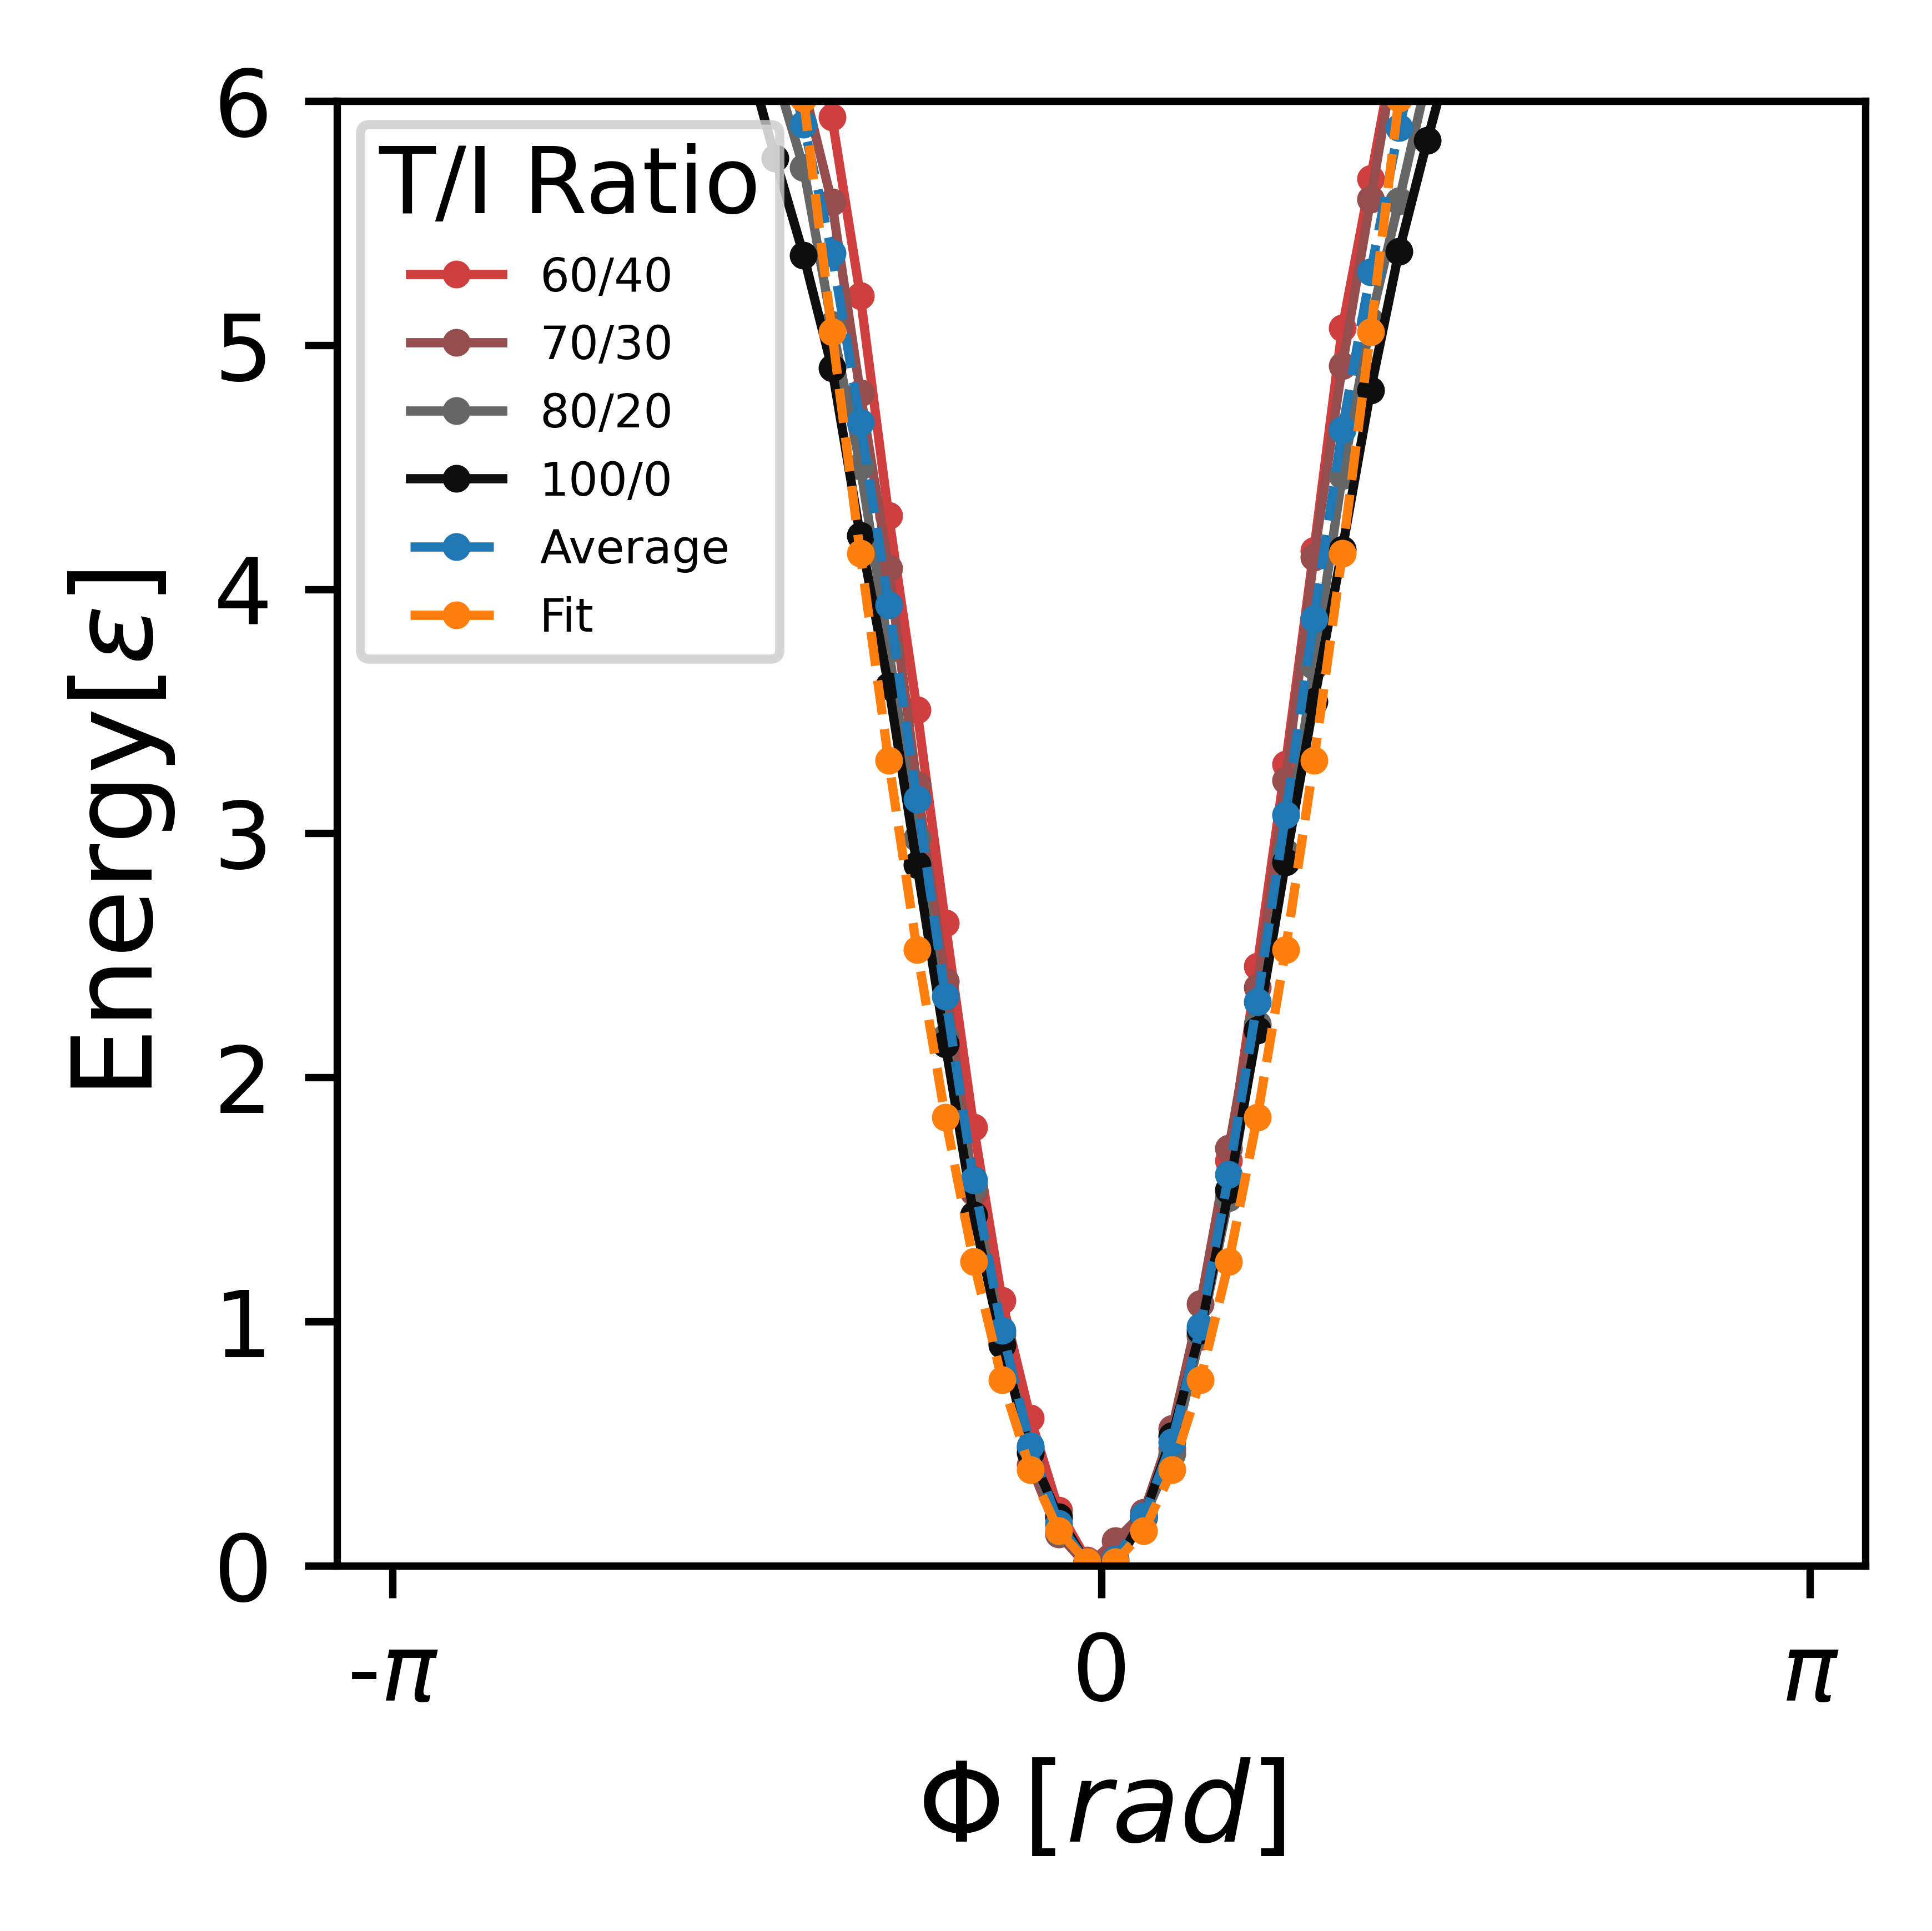

In [33]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
kT = 6.5
weights = []
avg_dists = []
n_bins = 50
save_file = False
avg_dih_inverse = np.zeros(n_bins)

for weight, jobs in project.find_jobs(filter={"polymer_lengths": [20], "kT_quench": kT}).groupby("para_weight"):
    weight_dist = np.zeros(n_bins)
    for job in jobs:
        ddist = dihedral_distribution(
            gsd_file = job.fn("components.gsd"),
            A_name = "E",
            B_name = "K",
            C_name = "K",
            D_name = "E",
            start=-1000,
            histogram=True,
            normalize=True,
            bins=n_bins,
        )
        smooth = savitzky_golay(ddist[:,1], window_size=5, order=1)
        weight_dist += smooth

    V = -kT*np.log(weight_dist/5)
    V -= V.min()
    avg_dih_inverse += V
    plt.plot(ddist[:,0], V, c=color_dict[weight], label=label_conv[weight])
    
    if save_file:
        dphi = ddist[:,0][1] - ddist[:,0][0]
        save_table_potential(
            potential=avg_dih_inverse/4,
            r=ddist[:,0],
            dr=dphi,
            potential_file=f"E-K-K-E_dihedral_{kT}kT.txt",
            iteration=None
        )
    
ax.plot(ddist[:,0], avg_dih_inverse/4, ls="--", label="Average")
harmonic_fit = hoomd_dihedral(ddist[:,0], 0, k=16, d=-1, n=1)
ax.plot(ddist[:,0], harmonic_fit, "o--", label="Fit")

ax.legend(title="T/I Ratio", loc="upper left", fontsize=5)
ax.set_xlabel("$\Phi\,[rad]$")
ax.set_ylabel("Energy$[\epsilon]$")
ax.set_ylim(0, 6)
ax.set_xticks([-np.pi, 0, np.pi], ["-$\pi$", 0, "$\pi$"])
fig.tight_layout()
#plt.savefig(f"../figures/ekke-dihedral-boltz-inverse-{kT}kT.png")

### KEKK Boltzmann Inverse

<>:47: DeprecationWarning: invalid escape sequence '\P'
<>:48: DeprecationWarning: invalid escape sequence '\e'
<>:49: DeprecationWarning: invalid escape sequence '\p'
<>:49: DeprecationWarning: invalid escape sequence '\p'
<>:47: DeprecationWarning: invalid escape sequence '\P'
<>:48: DeprecationWarning: invalid escape sequence '\e'
<>:49: DeprecationWarning: invalid escape sequence '\p'
<>:49: DeprecationWarning: invalid escape sequence '\p'
/tmp/ipykernel_973130/972008281.py:47: DeprecationWarning: invalid escape sequence '\P'
  ax.set_xlabel("$\Phi$ (rad)")
/tmp/ipykernel_973130/972008281.py:48: DeprecationWarning: invalid escape sequence '\e'
  ax.set_ylabel("Energy($\epsilon$)")
/tmp/ipykernel_973130/972008281.py:49: DeprecationWarning: invalid escape sequence '\p'
  ax.set_xticks([-np.pi, 0, np.pi], ["-$\pi$", 0, "$\pi$"])
/tmp/ipykernel_973130/972008281.py:49: DeprecationWarning: invalid escape sequence '\p'
  ax.set_xticks([-np.pi, 0, np.pi], ["-$\pi$", 0, "$\pi$"])


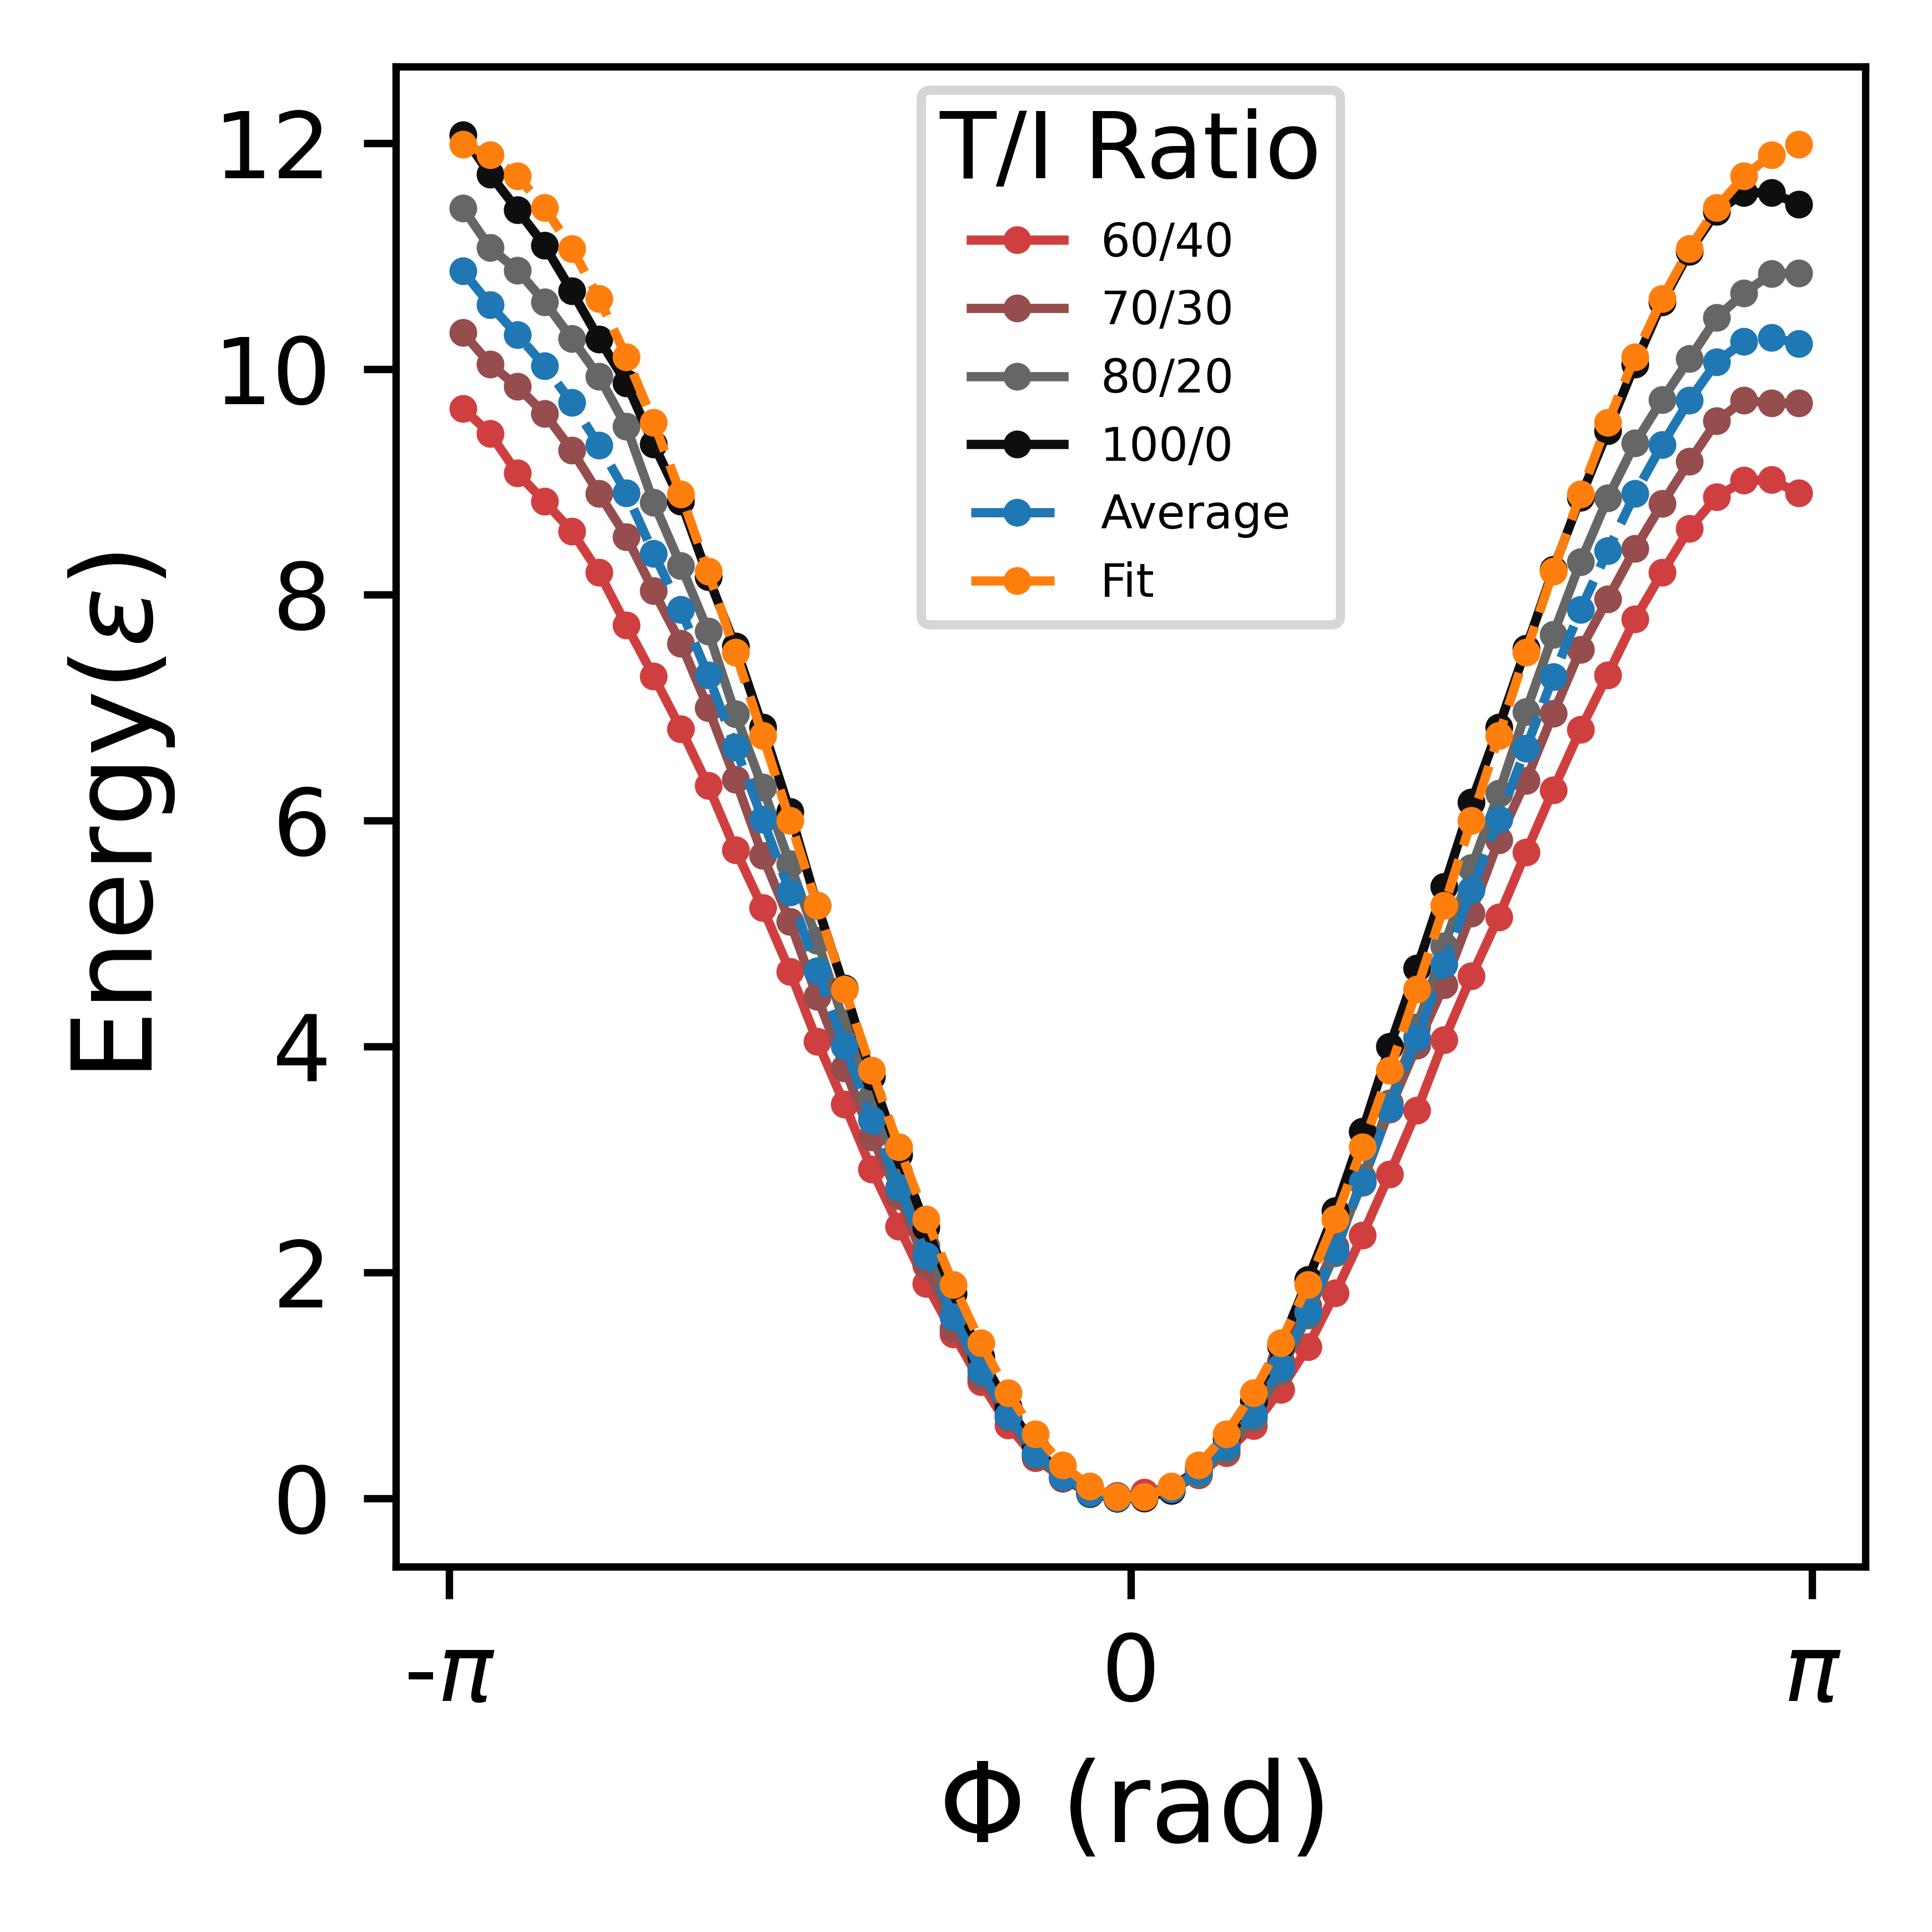

In [31]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
kT = 6.5
weights = []
avg_dists = []
n_bins = 50
save_file = False
avg_dih_inverse = np.zeros(n_bins)

for weight, jobs in project.find_jobs(filter={"polymer_lengths": [20], "kT_quench": kT}).groupby("para_weight"):
    weight_dist = np.zeros(n_bins)
    for job in jobs:
        ddist = dihedral_distribution(
            gsd_file = job.fn("components.gsd"),
            A_name = "K",
            B_name = "E",
            C_name = "K",
            D_name = "K",
            start=-1000,
            histogram=True,
            normalize=True,
            bins=n_bins,
        )
        smooth = savitzky_golay(ddist[:,1], window_size=5, order=1)
        weight_dist += smooth

    V = -kT*np.log(weight_dist/5)
    V -= V.min()
    avg_dih_inverse += V
    plt.plot(ddist[:,0], V, c=color_dict[weight], label=label_conv[weight])
    
    if save_file:
        dphi = ddist[:,0][1] - ddist[:,0][0]
        save_table_potential(
            potential=avg_dih_inverse/4,
            r=ddist[:,0],
            dr=dphi,
            potential_file=f"K-E-K-K_dihedral_{kT}kT.txt",
            iteration=None
        )
    
ax.plot(ddist[:,0], avg_dih_inverse/4, ls="--", label="Average")
harmonic_fit = hoomd_dihedral(ddist[:,0], 0, k=12, d=-1, n=1)
ax.plot(ddist[:,0], harmonic_fit, "o--", label="Fit")

#ax.set_ylim(0, 1.25)
ax.legend(title="T/I Ratio", loc="upper center", fontsize=5)
ax.set_xlabel("$\Phi$ (rad)")
ax.set_ylabel("Energy($\epsilon$)")
ax.set_xticks([-np.pi, 0, np.pi], ["-$\pi$", 0, "$\pi$"])
fig.tight_layout()
#plt.savefig(f"../figures/ekke-dihedral-boltz-inverse-{kT}kT.png")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
kT = 6.5
weights = []
avg_dists = []
n_bins = 50

save_file = True

avg_dih_inverse = np.zeros(n_bins)

for weight, jobs in project.find_jobs(filter={"polymer_lengths": [20], "kT_quench": kT}).groupby("para_weight"):
    weight_dist = np.zeros(n_bins)
    for job in jobs:
        ddist = dihedral_distribution(
            gsd_file = job.fn("components.gsd"),
            A_name = "K",
            B_name = "E",
            C_name = "K",
            D_name = "K",
            start=-1000,
            histogram=True,
            normalize=True,
            bins=n_bins,
        )
        smooth = savitzky_golay(ddist[:,1], window_size=5, order=1)
        weight_dist += smooth

    V = -kT*np.log(weight_dist/5)
    V -= V.min()
    avg_dih_inverse += V
    plt.plot(ddist[:,0], V, c=color_dict[weight], label=weight)
    
    if save_file:
        dphi = ddist[:,0][1] - ddist[:,0][0]
        save_table_potential(
            potential=avg_dih_inverse/4,
            r=ddist[:,0],
            dr=dphi,
            potential_file=f"/home/chris/cme/projects/pekk-msibi-final/msibi-runs/angles/K-E-K-K_dihedral.txt",
            iteration=None
        )
    
ax.plot(ddist[:,0], avg_dih_inverse/4, ls="--", label="Average")
#harmonic_fit = hoomd_dihedral(ddist[:,0], 0, k=12, d=-1, n=1)
#ax.plot(ddist[:,0], harmonic_fit, "k--")

#ax.set_ylim(0, 1.25)
#ax.set_title("EKKE Dihedral")    
ax.legend(title="T/I Ratio", loc="upper center")
ax.set_xlabel("$\Phi$ (rad)")
ax.set_ylabel("Energy($\epsilon$)")
ax.set_xticks([-np.pi, 0, np.pi], ["-$\pi$", 0, "$\pi$"])
fig.tight_layout()
#plt.savefig(f"../figures/kekk-dihedral-boltz-inverse-{kT}kT.png")

# Bond Lengths:  <a name="bondlengths"></a>

<>:51: DeprecationWarning: invalid escape sequence '\s'
<>:51: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_973130/1181211189.py:51: DeprecationWarning: invalid escape sequence '\s'
  ax.set_xlabel("$L[\sigma]$")


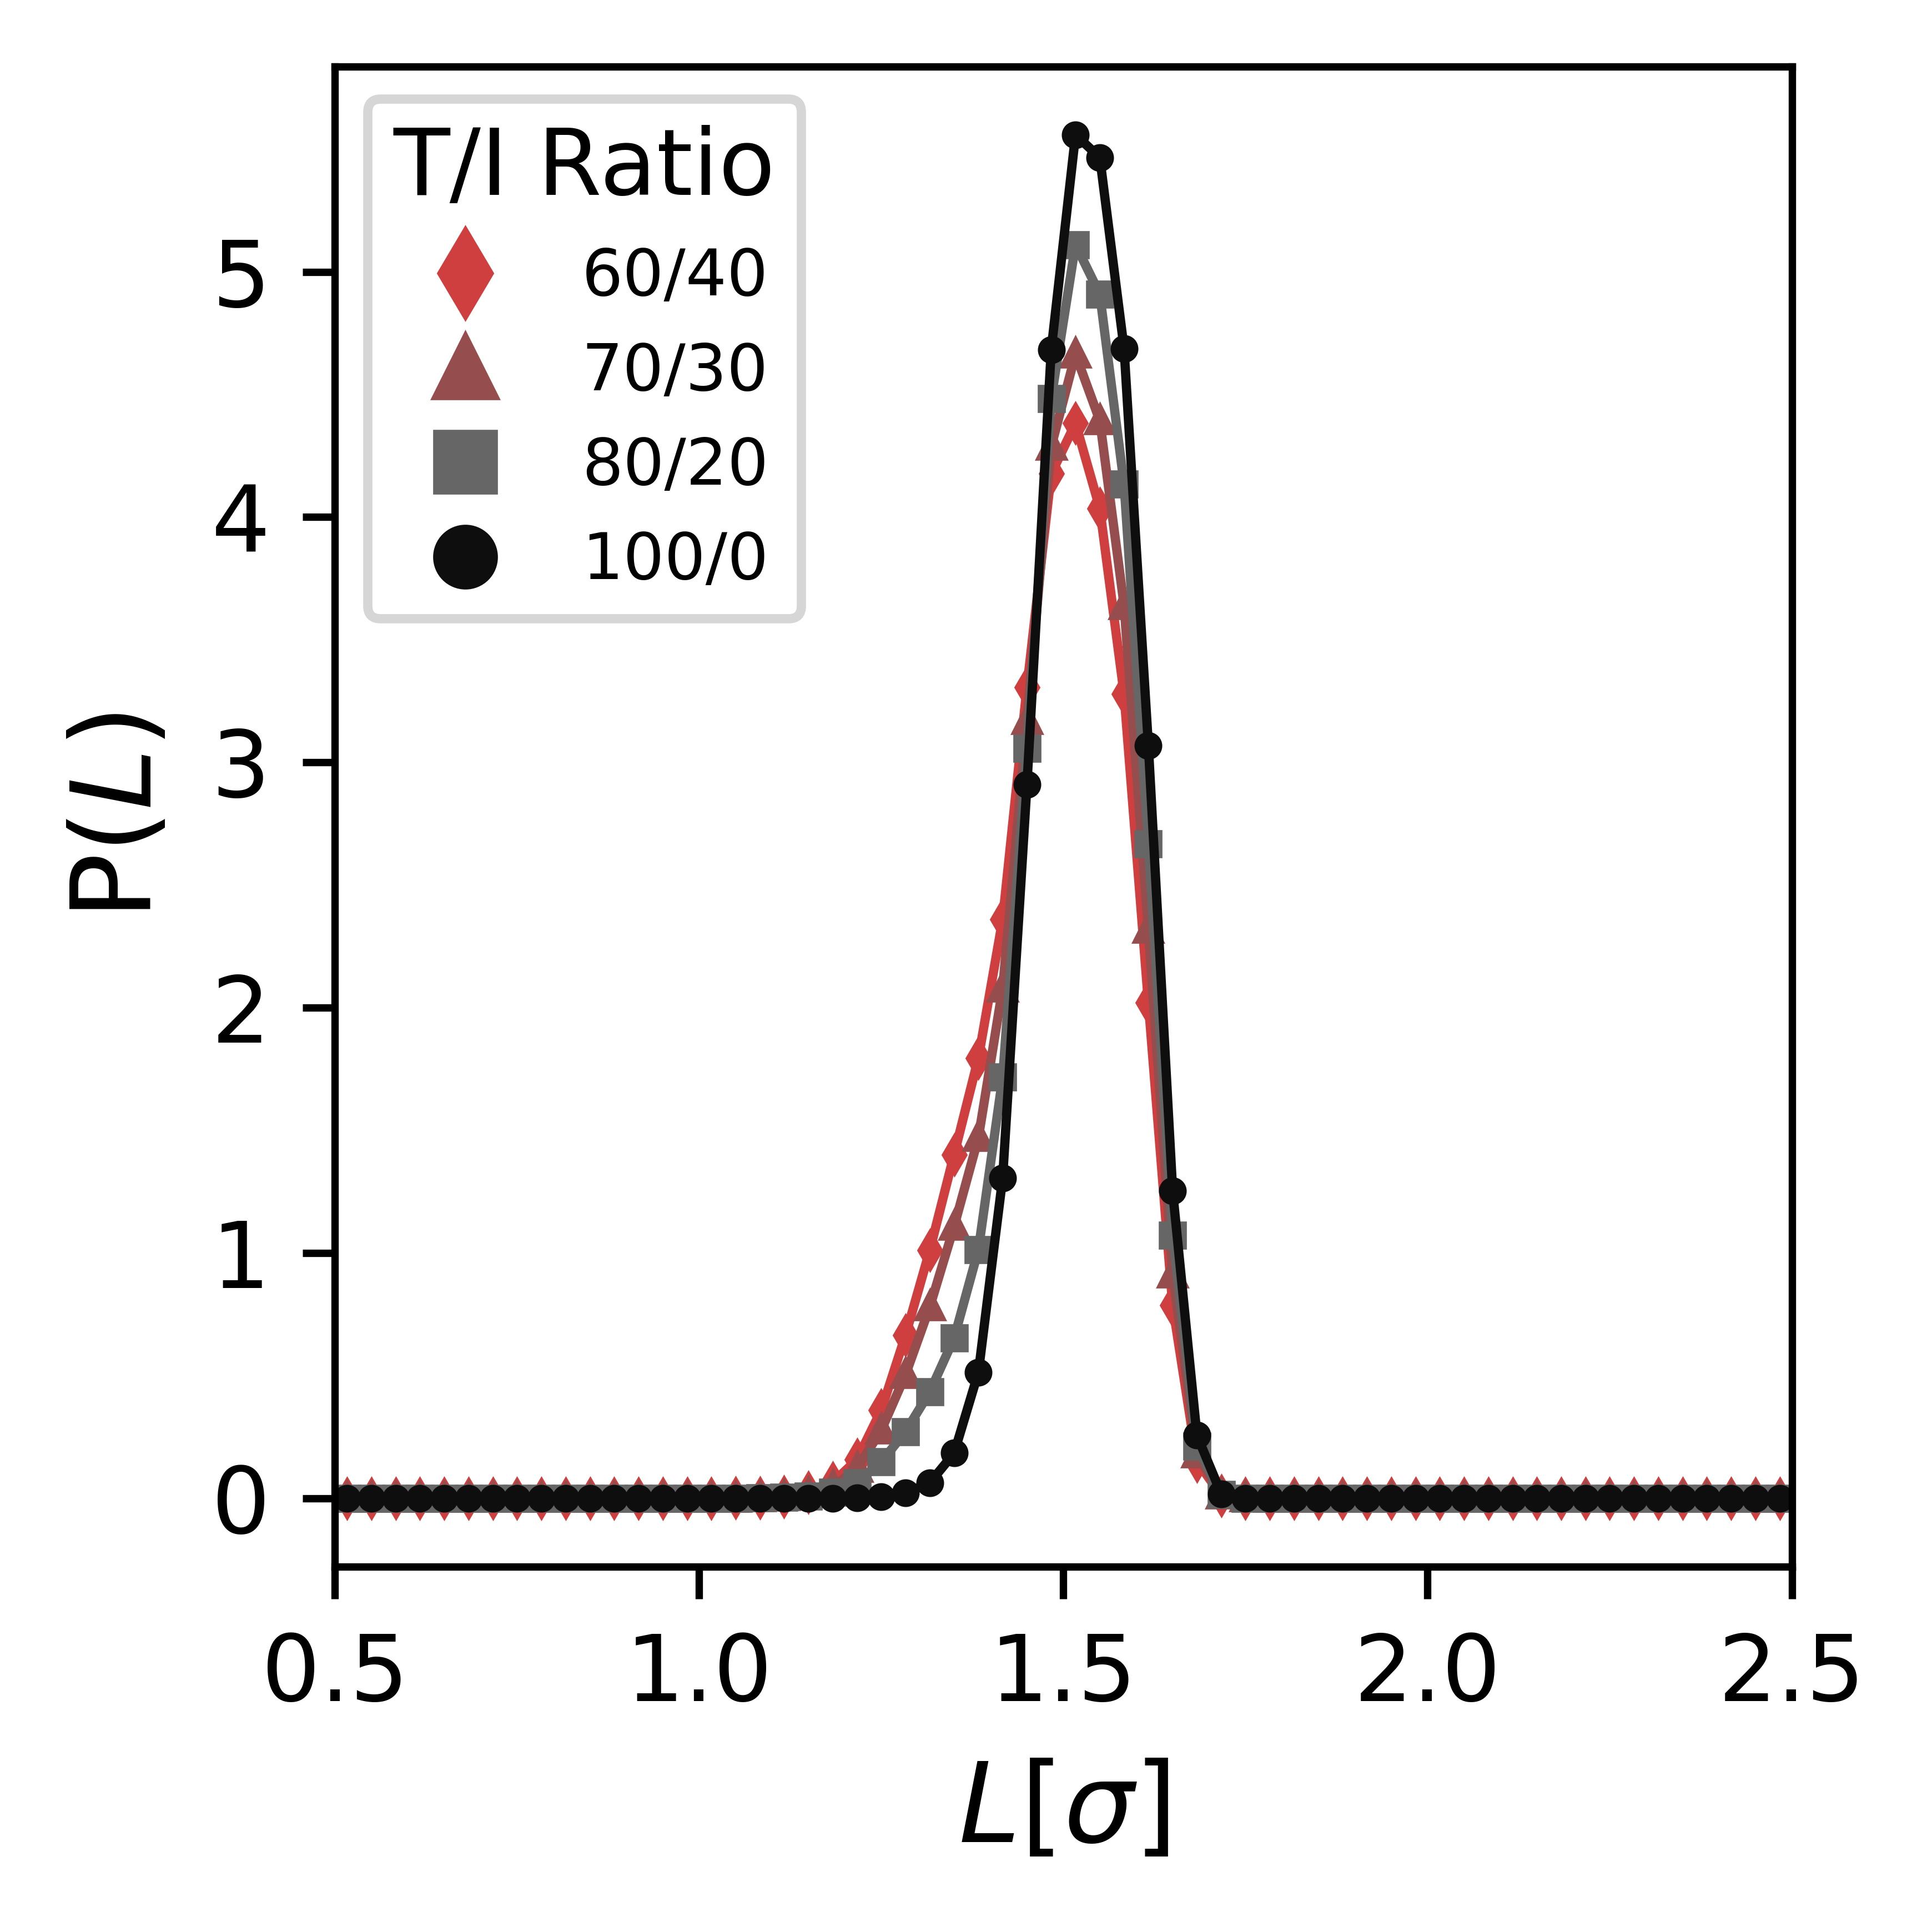

In [10]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
kT = 6.5
l_min = 0.5
l_max = 2.5
n_bins = 60
bond="KK"

weights = []
avg_dists = []

for weight, jobs in project.find_jobs(filter={"polymer_lengths": [20], "kT_quench": kT}).groupby("para_weight"):
    weight_dist = np.zeros(n_bins)
    for job in jobs:
        bdist = bond_distribution(
            gsd_file=job.fn("components.gsd"),
            A_name=bond[0],
            B_name=bond[1],
            start=-1000,
            histogram=True,
            normalize=True,
            bins=n_bins,
            l_min=l_min,
            l_max=l_max
        )
        smooth = savitzky_golay(bdist[:,1], window_size=5, order=1)
        weight_dist += smooth
        
    stride = np.arange(0, len(bdist[:,0]), 1)
    ax.plot(
        bdist[:,0],
        weight_dist/5,
        c=color_dict[weight],
        markersize=0
    )
    ax.plot(
        bdist[:,0][stride],
        weight_dist[stride]/5,
        label=label_conv[weight],
        c=color_dict[weight],
        linewidth=0,
        marker=symbol_dict[weight]
    )

    save_distribution = np.stack((bdist[:,0], weight_dist/5)).T
    np.savetxt(f"{bond}_target_dist_{kT}kT.txt", save_distribution)


ax.legend(title="T/I Ratio", loc="upper left", markerscale=3)
ax.set_xlim(0.5, 2.5)
ax.set_xlabel("$L[\sigma]$")
ax.set_ylabel("P($L$)")
fig.tight_layout()
plt.savefig(f"figures/{bond}-bond-dist-{kT}kT.png")

## Boltzmann Inverse of bonds:

<>:37: DeprecationWarning: invalid escape sequence '\s'
<>:38: DeprecationWarning: invalid escape sequence '\e'
<>:37: DeprecationWarning: invalid escape sequence '\s'
<>:38: DeprecationWarning: invalid escape sequence '\e'
/tmp/ipykernel_973130/3168876939.py:37: DeprecationWarning: invalid escape sequence '\s'
  plt.xlabel("$L$ $[\sigma]$")
/tmp/ipykernel_973130/3168876939.py:38: DeprecationWarning: invalid escape sequence '\e'
  plt.ylabel("Energy$[\epsilon]$")
/tmp/ipykernel_973130/3168876939.py:26: RuntimeWarning: divide by zero encountered in log
  V = -kT*np.log(weight_dist/5)


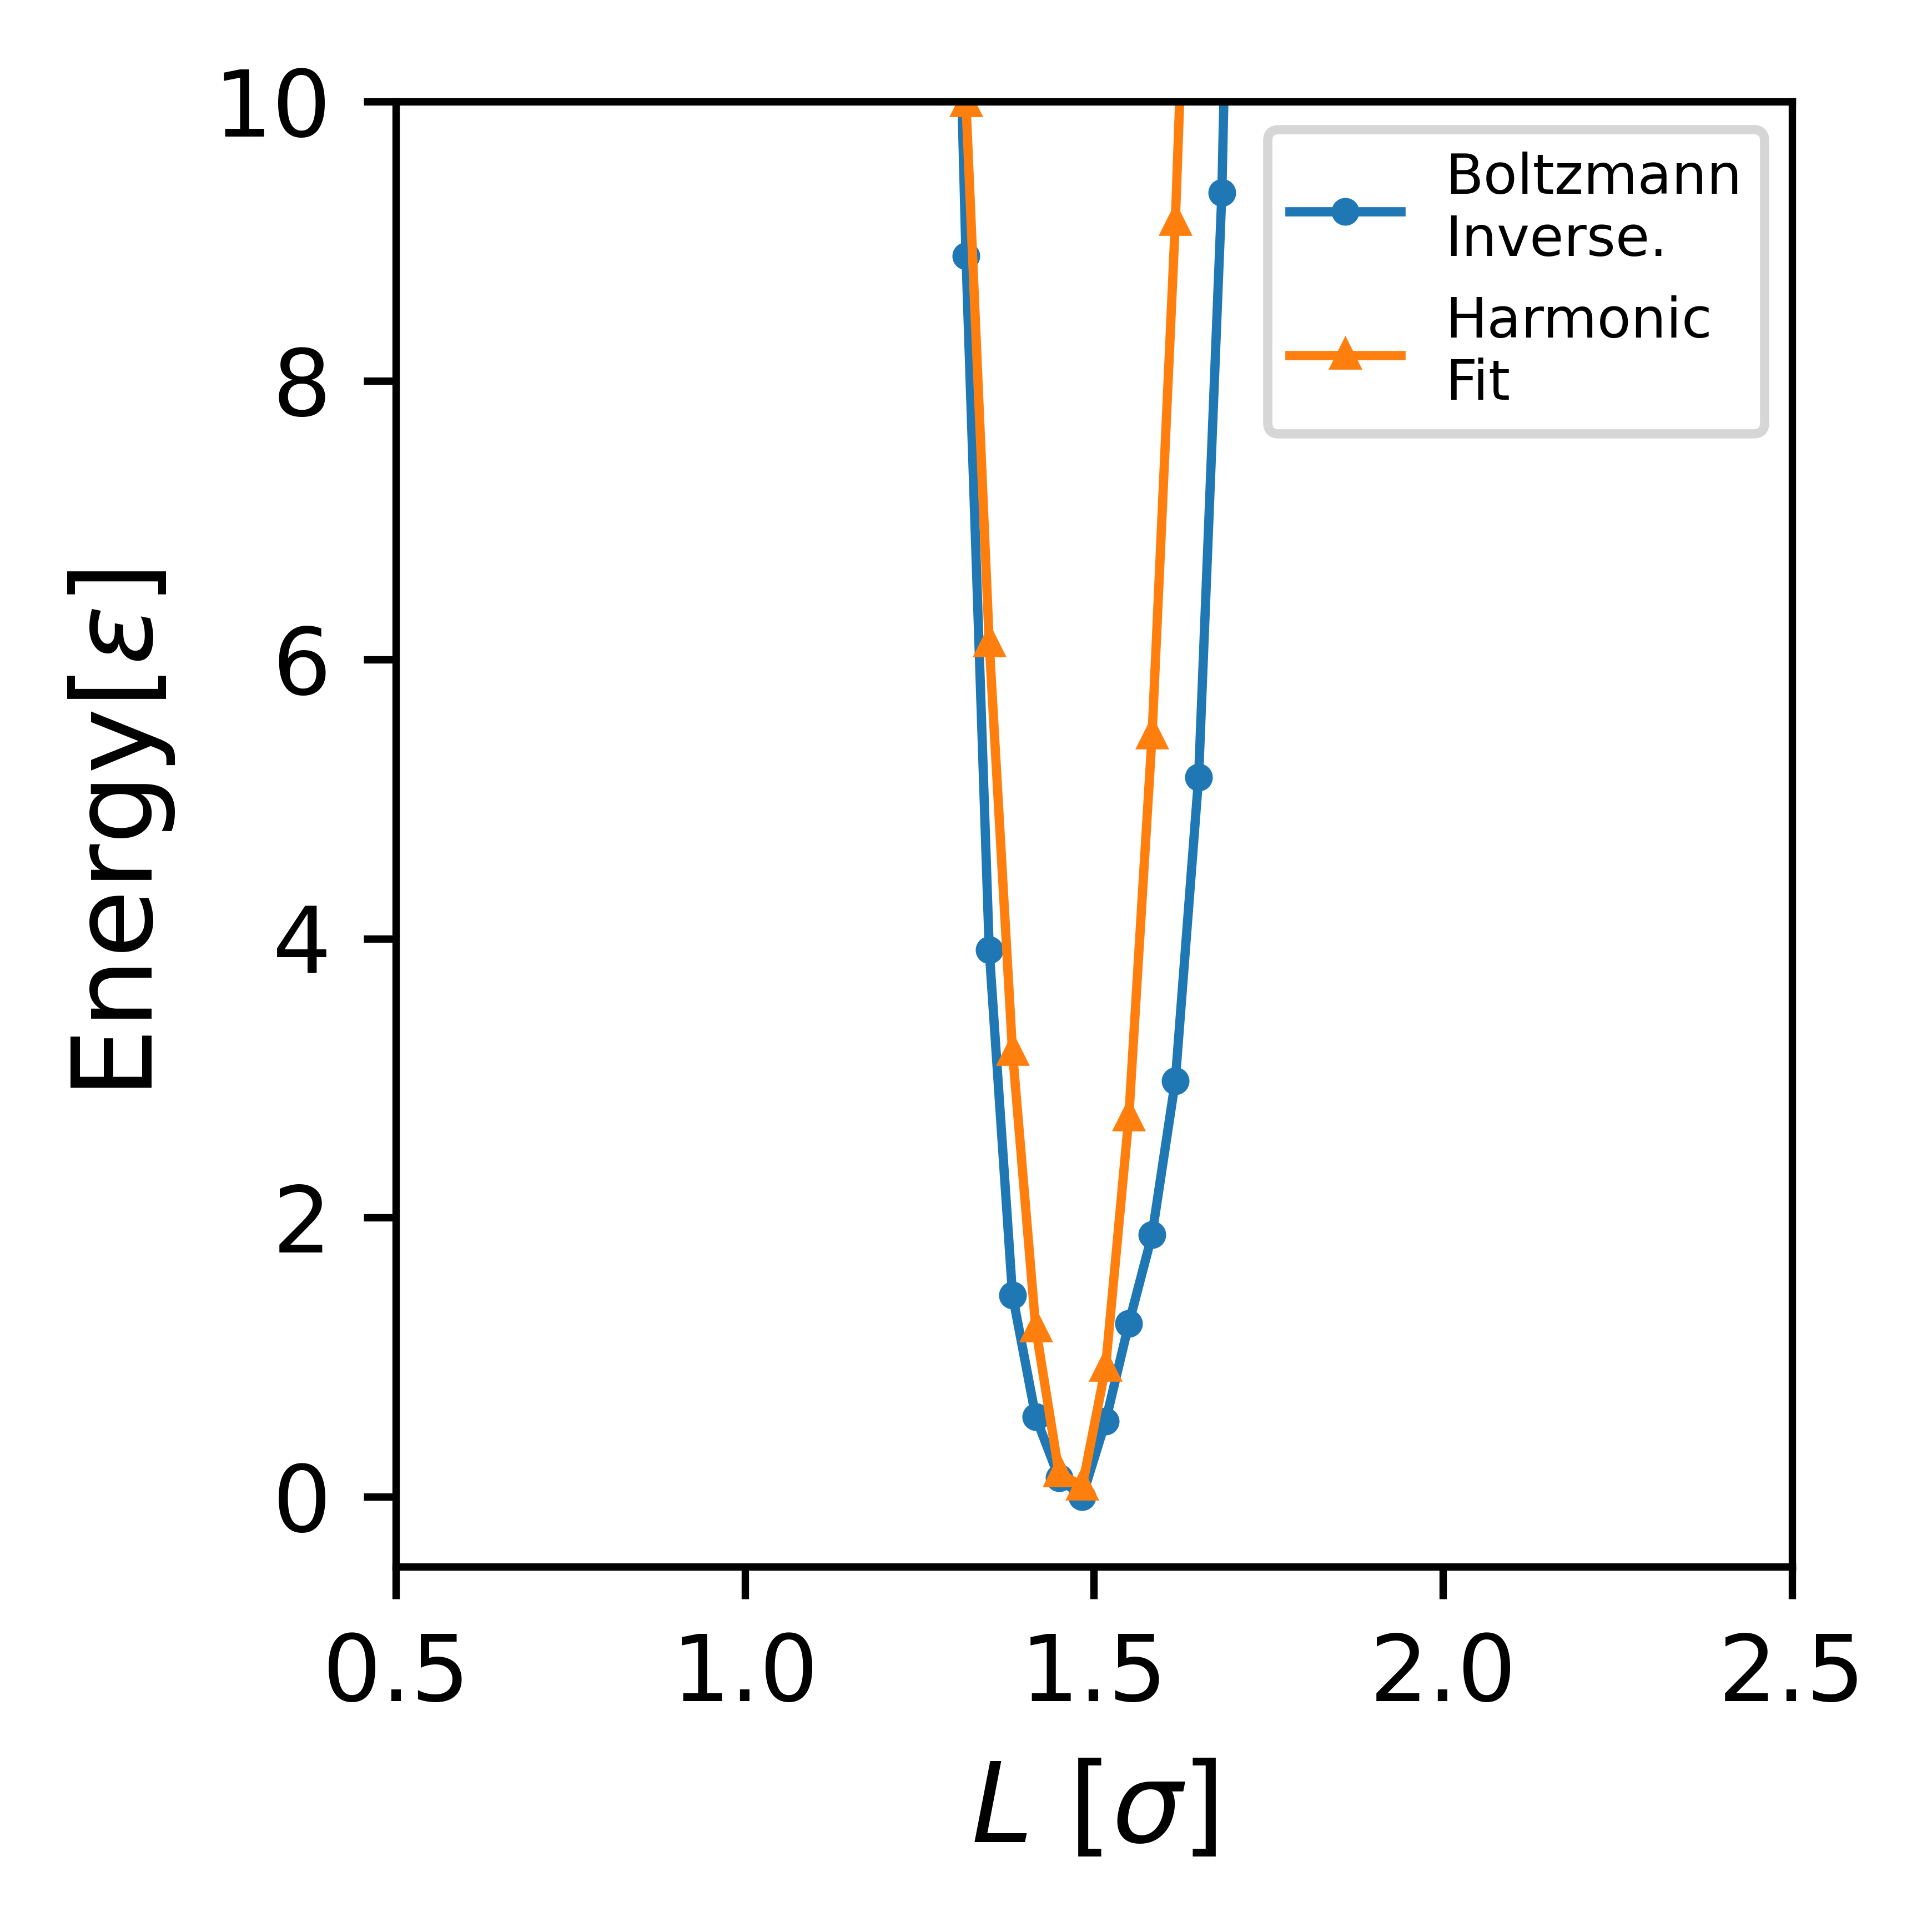

In [28]:
kT = 6.5
n_bins = 60
l_min = 0.5
l_max = 2.5
dl = (l_max - l_min) / (n_bins - 1)

fig = plt.figure()
avg_bond_inverse = np.zeros(n_bins)
for weight, jobs in project.find_jobs(filter={"polymer_lengths": [20], "kT_quench": kT}).groupby("para_weight"):
    weight_dist = np.zeros(n_bins)
    for job in jobs:
        bdist = bond_distribution(
            gsd_file = job.fn("components.gsd"),
            A_name = "E",
            B_name = "K",
            start=-1000,
            histogram=True,
            normalize=True,
            bins=n_bins,
            l_min=l_min,
            l_max=l_max
        )
        smooth = savitzky_golay(bdist[:,1], window_size=5, order=1)
        weight_dist += smooth

    V = -kT*np.log(weight_dist/5)
    V -= V.min()
    avg_bond_inverse += V
    
plt.plot(bdist[:,0], avg_bond_inverse/4, "o-", label="Boltzmann\nInverse.")
harmonic_fit = bond_harmonic(bdist[:,0], 1.47, k=850)
plt.plot(bdist[:,0], harmonic_fit, "^-", label="Harmonic\nFit")
    
plt.xlim(0.5, 2.5)
plt.ylim(-.5, 10)
plt.legend(loc="upper right", fontsize=6)
plt.xlabel("$L$ $[\sigma]$")
plt.ylabel("Energy$[\epsilon]$")
fig.tight_layout()
plt.savefig(f"figures/EK-bond-boltz-inverse-{kT}kT.png")

<>:37: DeprecationWarning: invalid escape sequence '\s'
<>:38: DeprecationWarning: invalid escape sequence '\e'
<>:37: DeprecationWarning: invalid escape sequence '\s'
<>:38: DeprecationWarning: invalid escape sequence '\e'
/tmp/ipykernel_973130/3918722085.py:37: DeprecationWarning: invalid escape sequence '\s'
  plt.xlabel("$L$ $[\sigma]$")
/tmp/ipykernel_973130/3918722085.py:38: DeprecationWarning: invalid escape sequence '\e'
  plt.ylabel("Energy$[\epsilon]$")
/tmp/ipykernel_973130/3918722085.py:26: RuntimeWarning: divide by zero encountered in log
  V = -kT*np.log(weight_dist/5)


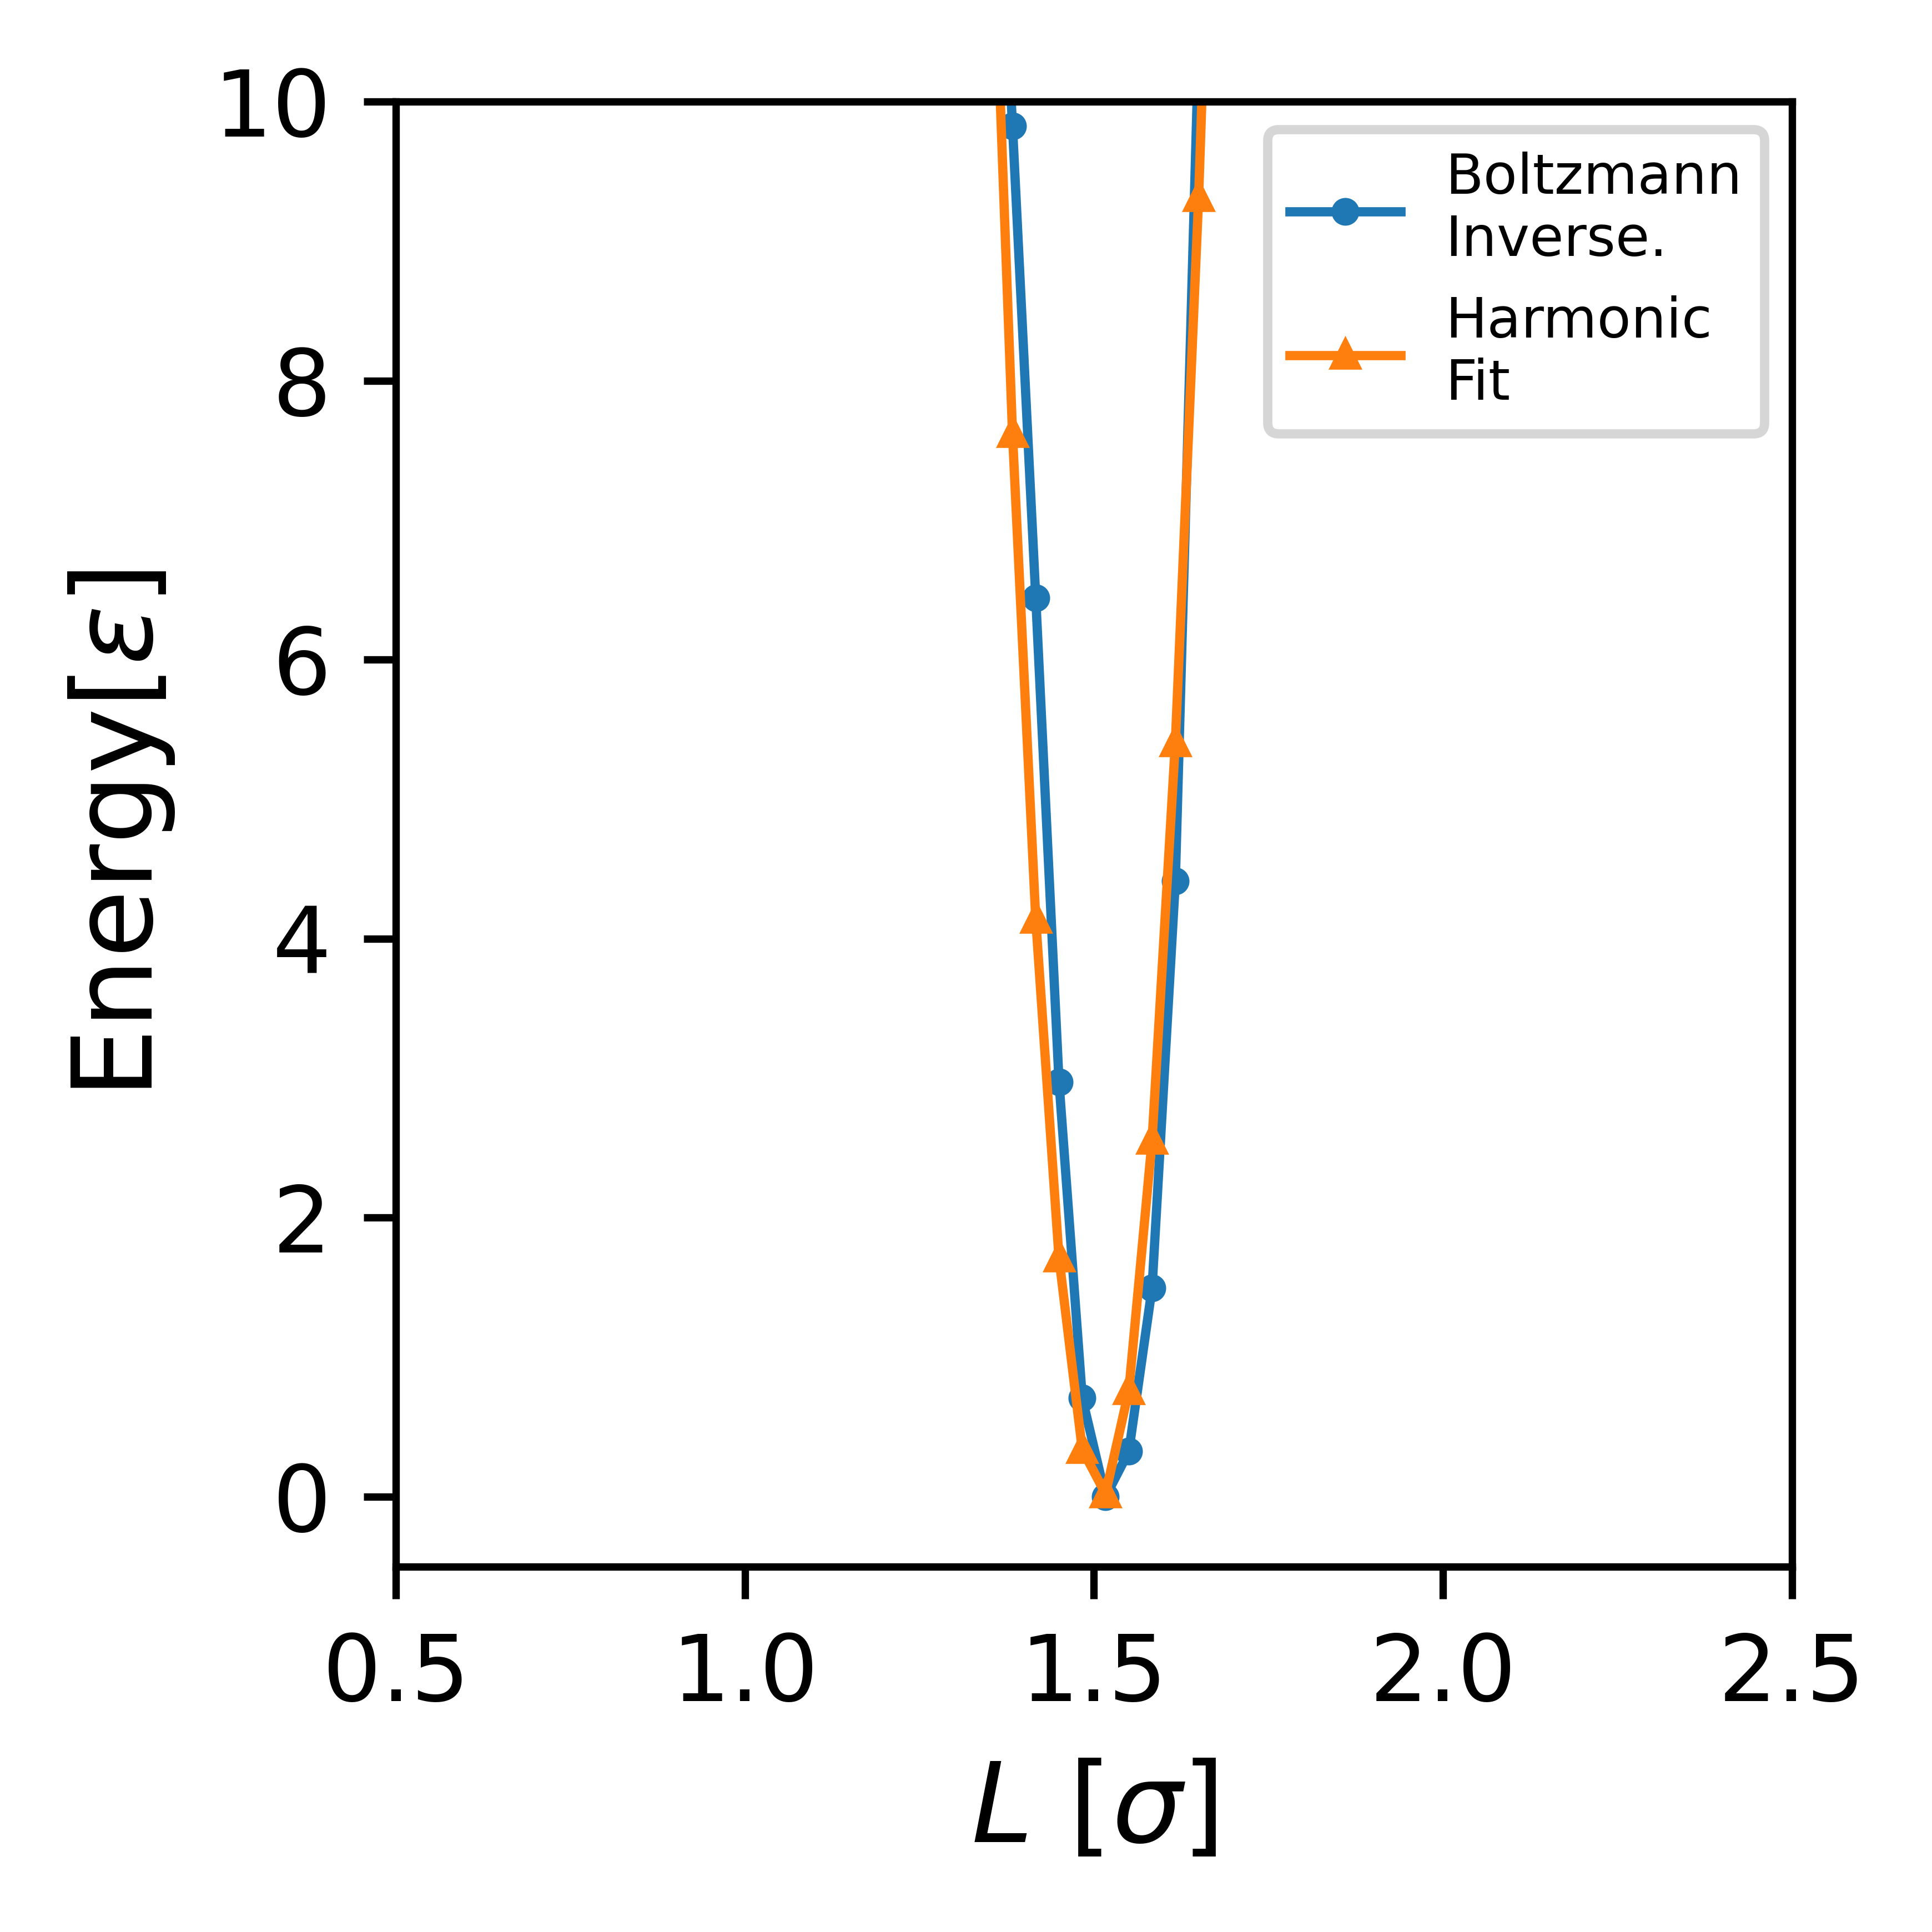

In [23]:
kT = 6.5
n_bins = 60
l_min = 0.5
l_max = 2.5
dl = (l_max - l_min) / (n_bins - 1)

fig = plt.figure()
avg_bond_inverse = np.zeros(n_bins)
for weight, jobs in project.find_jobs(filter={"polymer_lengths": [20], "kT_quench": kT}).groupby("para_weight"):
    weight_dist = np.zeros(n_bins)
    for job in jobs:
        bdist = bond_distribution(
            gsd_file = job.fn("components.gsd"),
            A_name = "K",
            B_name = "K",
            start=-1000,
            histogram=True,
            normalize=True,
            bins=n_bins,
            l_min=l_min,
            l_max=l_max
        )
        smooth = savitzky_golay(bdist[:,1], window_size=5, order=1)
        weight_dist += smooth

    V = -kT*np.log(weight_dist/5)
    V -= V.min()
    avg_bond_inverse += V
    
plt.plot(bdist[:,0], avg_bond_inverse/4, "o-", label="Boltzmann\nInverse.")
harmonic_fit = bond_harmonic(bdist[:,0], 1.51, k=950)
plt.plot(bdist[:,0], harmonic_fit, "^-", label="Harmonic\nFit")
    
plt.xlim(0.5, 2.5)
plt.ylim(-.5, 10)
plt.legend(loc="upper right", fontsize=6)
plt.xlabel("$L$ $[\sigma]$")
plt.ylabel("Energy$[\epsilon]$")
fig.tight_layout()
plt.savefig(f"figures/KK-bond-boltz-inverse-{kT}kT.png")